In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [101]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [102]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

In [103]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [104]:
y = train_data['loan_status']
test_data_id = test_data.id

In [105]:
def remove_column(dataset, columns):
    """
    Removes specified columns from the dataset.
    
    Parameters:
    ----------
        dataset : pandas.DataFrame
            The DataFrame from which columns will be removed.
        columns : list or str
            A list of column names or a single column name to be removed from the dataset.
            
    Returns:
    -------
        pandas.DataFrame
            The modified DataFrame with the specified columns removed.
    """
    dataset = dataset.drop(columns, axis=1)
    return dataset

In [106]:
X = remove_column(train_data, ['id', 'loan_status'])
test_data = remove_column(test_data, ['id'])

In [107]:
# CODE TO PRINT THE NULL DATAFRAME FOR BOTH THE DATASET
pd.DataFrame(X.isnull().sum(), columns = ['Train']).merge(pd.DataFrame(X.isnull().sum(), columns = ['Test']), left_index = True, right_index = True, how = 'outer')

,Train,Test
cb_person_cred_hist_length,0,0
cb_person_default_on_file,0,0
loan_amnt,0,0
loan_grade,0,0
loan_int_rate,0,0
loan_intent,0,0
loan_percent_income,0,0
person_age,0,0
person_emp_length,0,0
person_home_ownership,0,0


In [108]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB


In [109]:
X.person_emp_length.describe()

count    58645.000000
mean         4.701015
std          3.959784
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

In [110]:
def numerical_column(X):
    return X.select_dtypes(exclude = ['object']).columns

In [111]:
def categorical_column(X):
    return X.select_dtypes(include = ['object']).columns

In [112]:
X.cb_person_cred_hist_length.describe()

count    58645.000000
mean         5.813556
std          4.029196
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64

In [113]:
def feature_engineering(dataset):
    '''
    Do the feature engineering for the dataset
    
    Arguments:
    ---------
        pandas.DataFrame
    
    Results:
    --------
        pandas.DataFrame
    '''
    
    # CREATES THE income_labels FOR THE DATA 
    income_bins = [0, 42000, 58000, 75600, 100000, 200000, float('inf')]
    income_labels = ['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High', 'Very High']
    dataset['income_group'] = pd.cut(dataset['person_income'], bins=income_bins, labels=income_labels, right=False).astype(str)
    
    # CREATE THE person_emp_length FOR THE DATA 
    length_bins = [-1, 0, 3, 6, 10, float('inf')]
    length_labels = ['Unemployed', 'Entry-Level', 'Mid-Level', 'Experienced', 'Veteran']
    dataset['person_emp_length_group'] = pd.cut(dataset['person_emp_length'], bins = length_bins, labels = length_labels).astype(str)
    
    # CREATE THE cb_person_cred_hist_length FOR THE DATA 
    default_bins = [-1, 2, 5, 10, 20, float('inf')]
    default_labels = ['very low', 'low', 'mid', 'high', 'very high']
    dataset['default_group'] = pd.cut(dataset['cb_person_cred_hist_length'], bins=default_bins, labels=default_labels).astype(str)
    
    return dataset

In [114]:
X = feature_engineering(X)
test_data = feature_engineering(test_data)

In [115]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_group,person_emp_length_group,default_group
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,Low,Unemployed,high
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,Lower Middle,Mid-Level,very low
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,Low,Experienced,mid
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,Middle,Veteran,low
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,Middle,Entry-Level,low


In [116]:
def categorical_viz(dataset):
    """
    Visualizes the distribution of categorical columns in a dataset using count plots.
    
    Parameters:
    ----------
        dataset : pandas.DataFrame
            The DataFrame containing the categorical columns to be visualized.
            
    Returns:
    -------
        None
            Displays a grid of count plots for each categorical column in the dataset.
            
    Description:
    -----------
        - This function identifies categorical columns using the `categorical_column` helper function.
        - It creates a 2x4 grid of subplots, then plots a count plot for each categorical column in the dataset.
        - If there are fewer than 8 columns, the empty subplots are removed.
        - Each plot displays a title with the column name and rotates x-axis labels for readability.
        - The layout is adjusted to maintain clear spacing between plots.
    """
    
    column = categorical_column(dataset) 
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()  
    
    for i, col in enumerate(column):
        sns.countplot(data=dataset, x=col, ax=axes[i], color = 'skyblue')
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=90)  

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  

    plt.tight_layout(w_pad=3, h_pad=3)
    plt.suptitle('Countlpot for Categorical columns', fontsize = 16, fontweight = 'bold')
    plt.show()

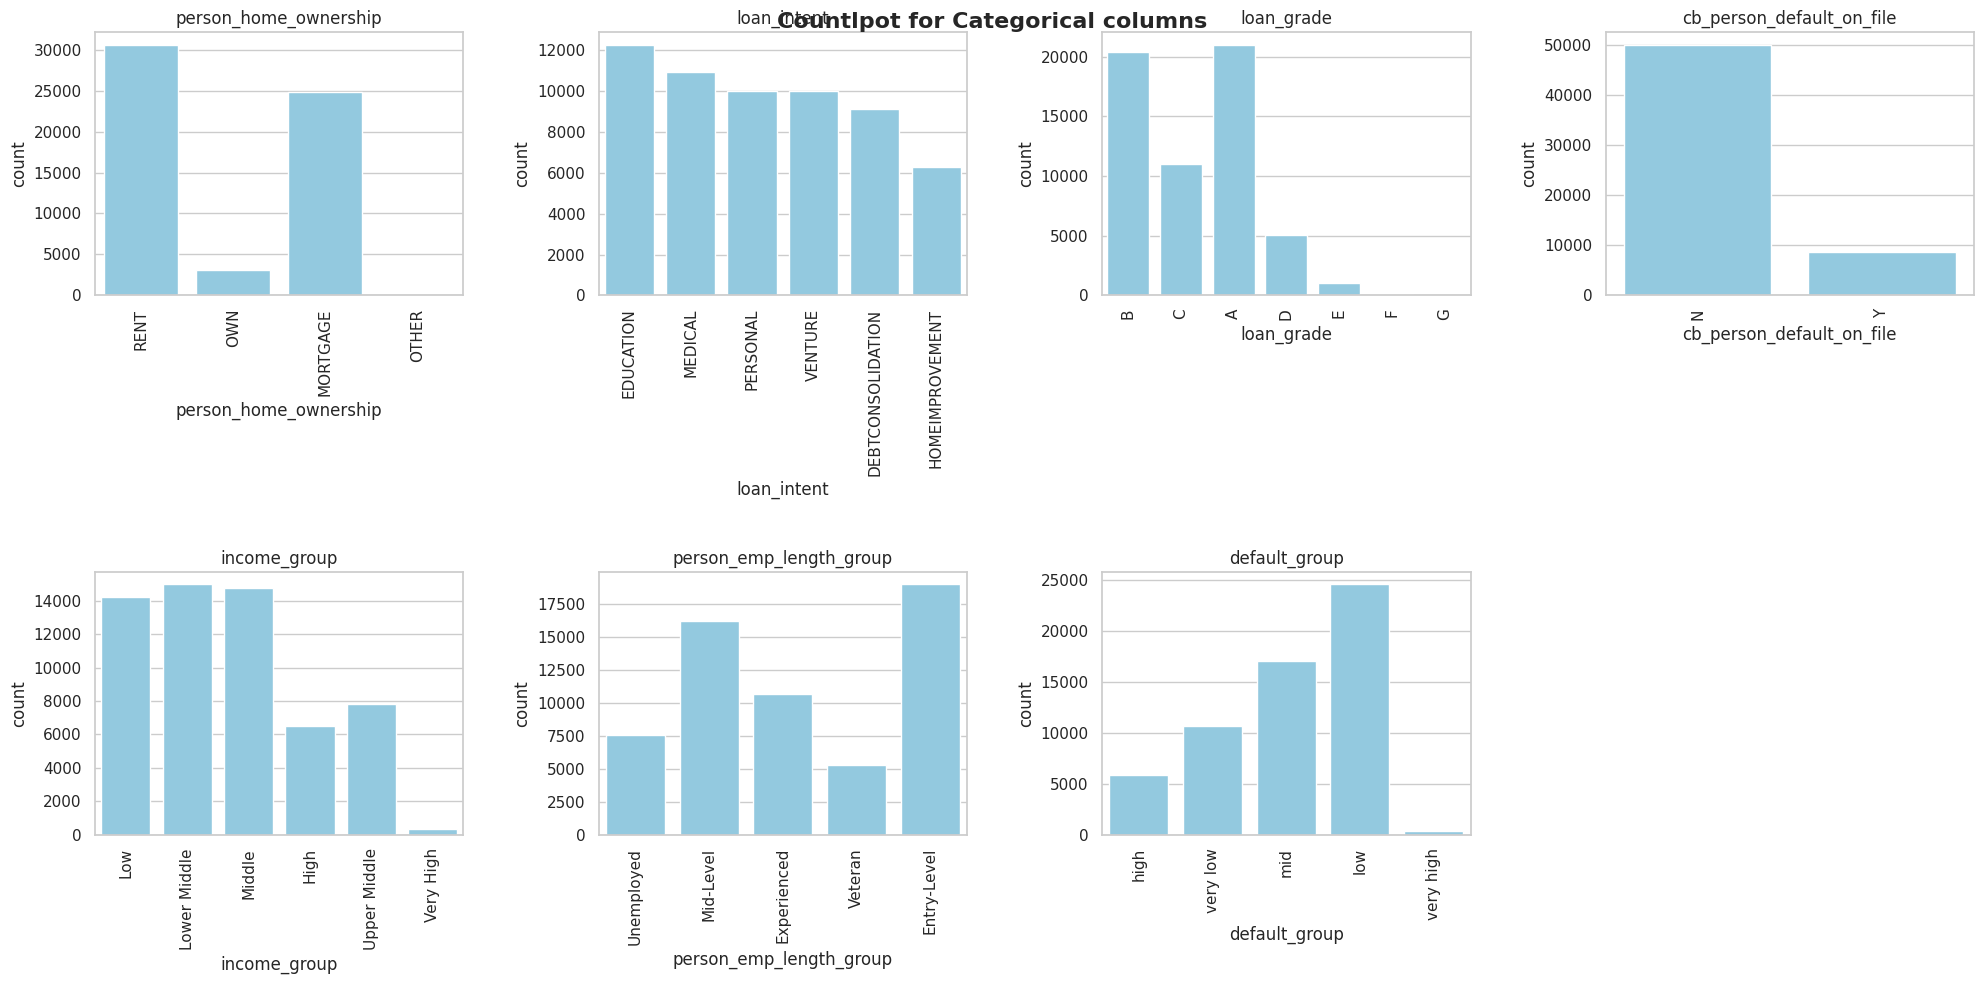

In [117]:
categorical_viz(X)

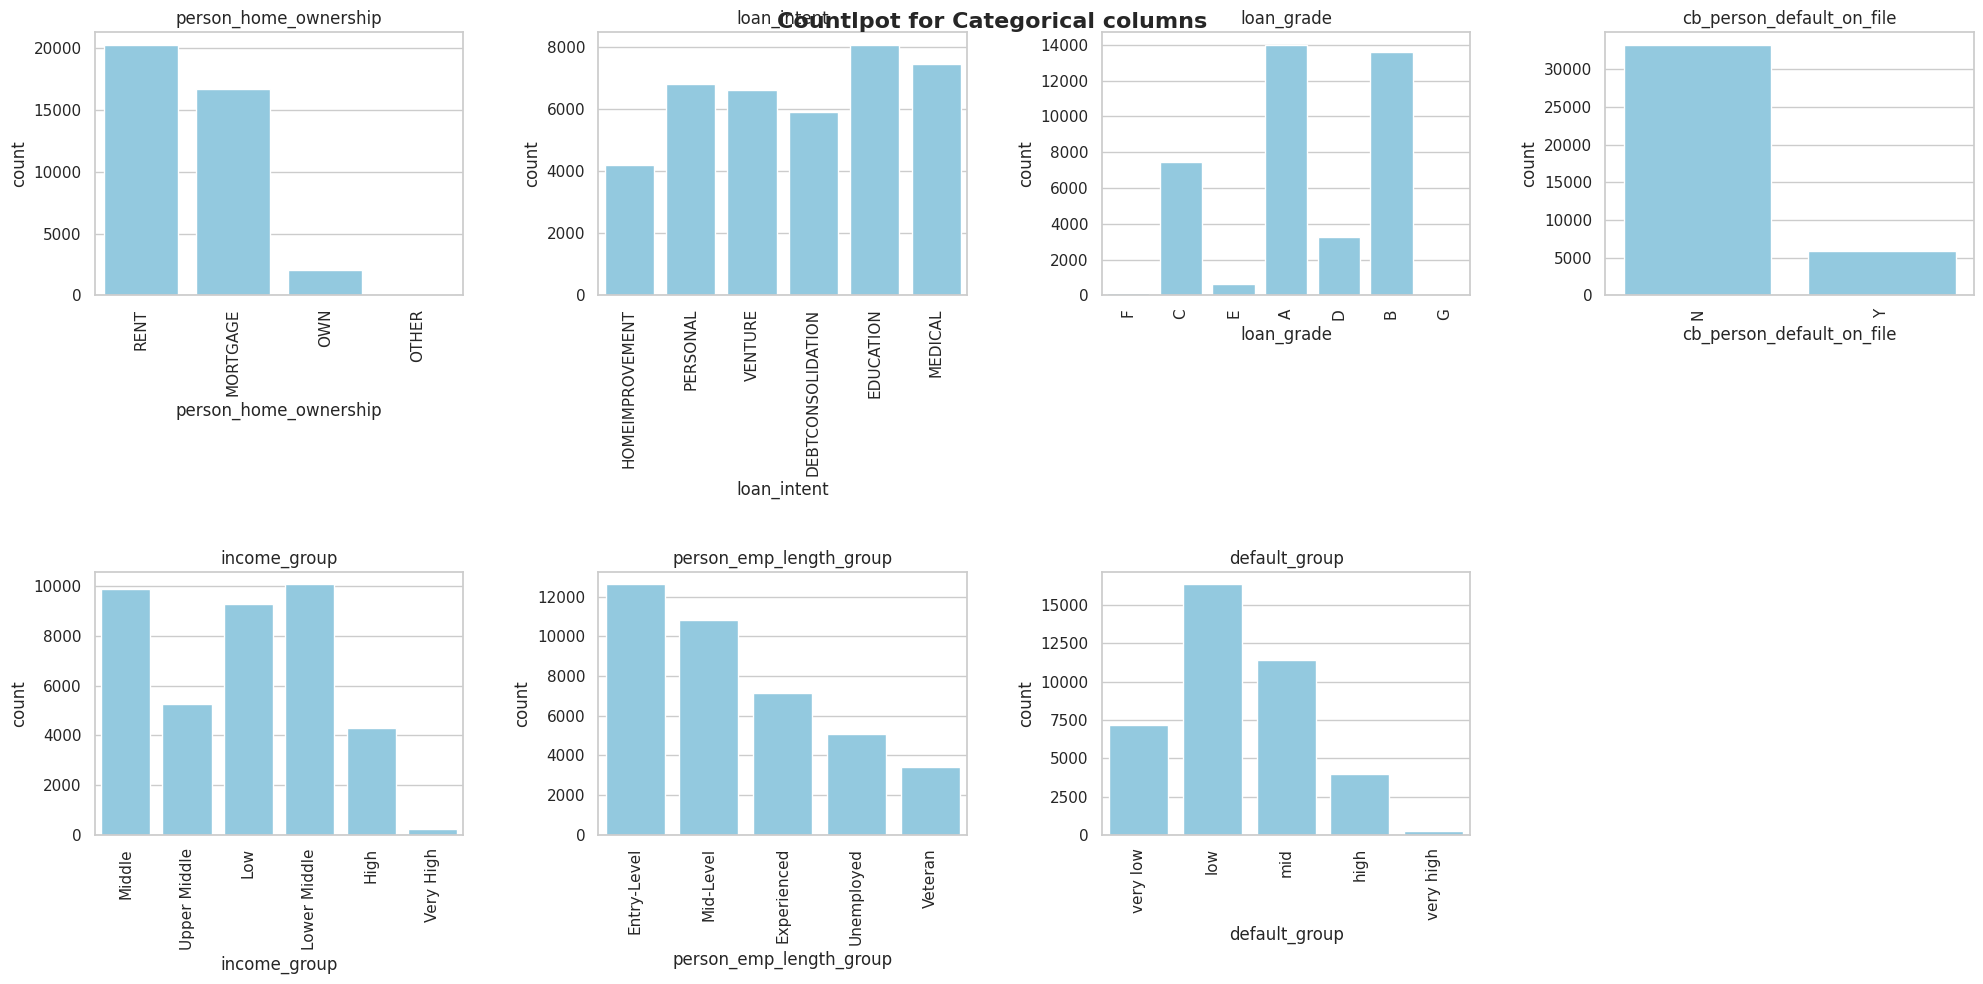

In [118]:
categorical_viz(test_data)

In [119]:
def numerical_viz(X):
    '''
    Plots the numerical data
    Arguments:
    ---------
        pandas.DataFrame
    Return:
    ------
        maplotlib plotting
    '''
    numerical_columns = numerical_column(X)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows and 4 columns
    axes = axes.flatten()  # Flatten the 2D array of axes
    # Plot KDE for each numerical column
    for i, column in enumerate(numerical_columns):
        sns.kdeplot(data=X, x=column, ax=axes[i], fill=True, color='#72BF78')
        axes[i].set_title(f'KDE Plot of {column}', fontsize=14)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')

    # Hide any unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('KDE Plots for Numerical Columns', fontsize=16, fontweight='bold')
    plt.show()

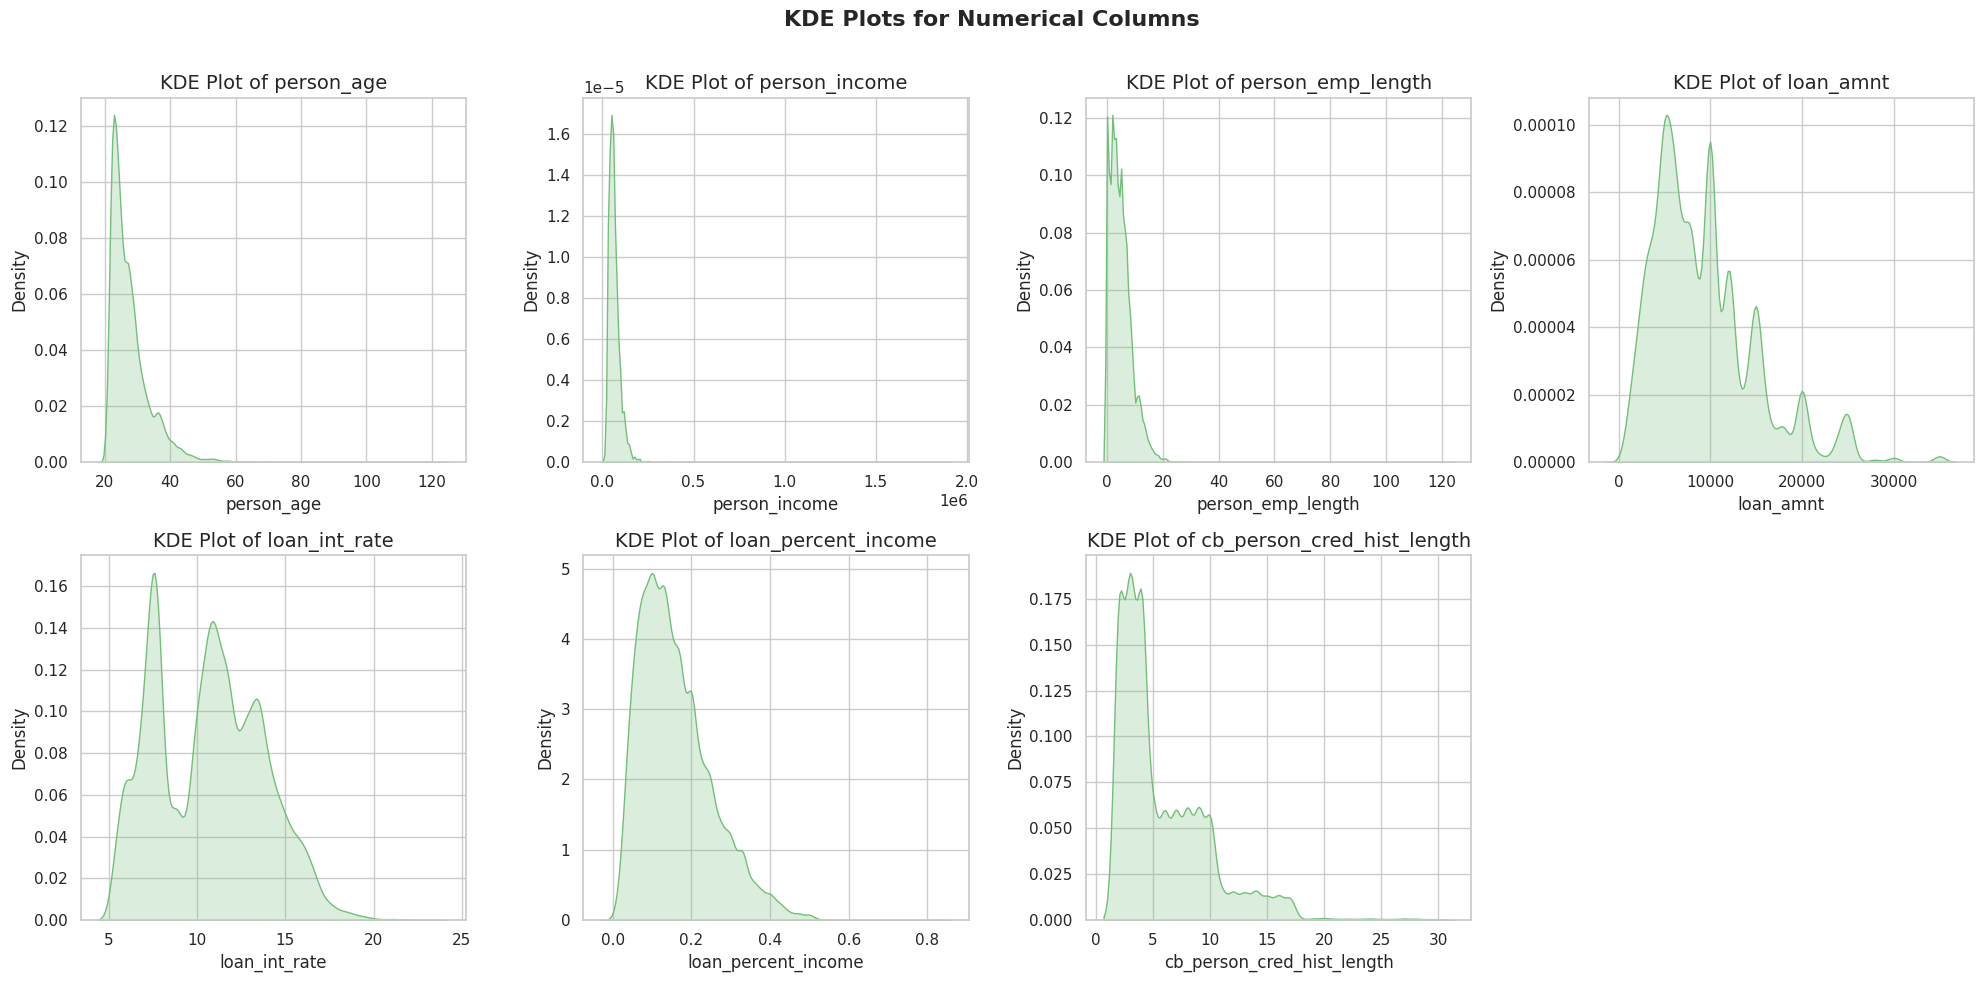

In [120]:
numerical_viz(X)

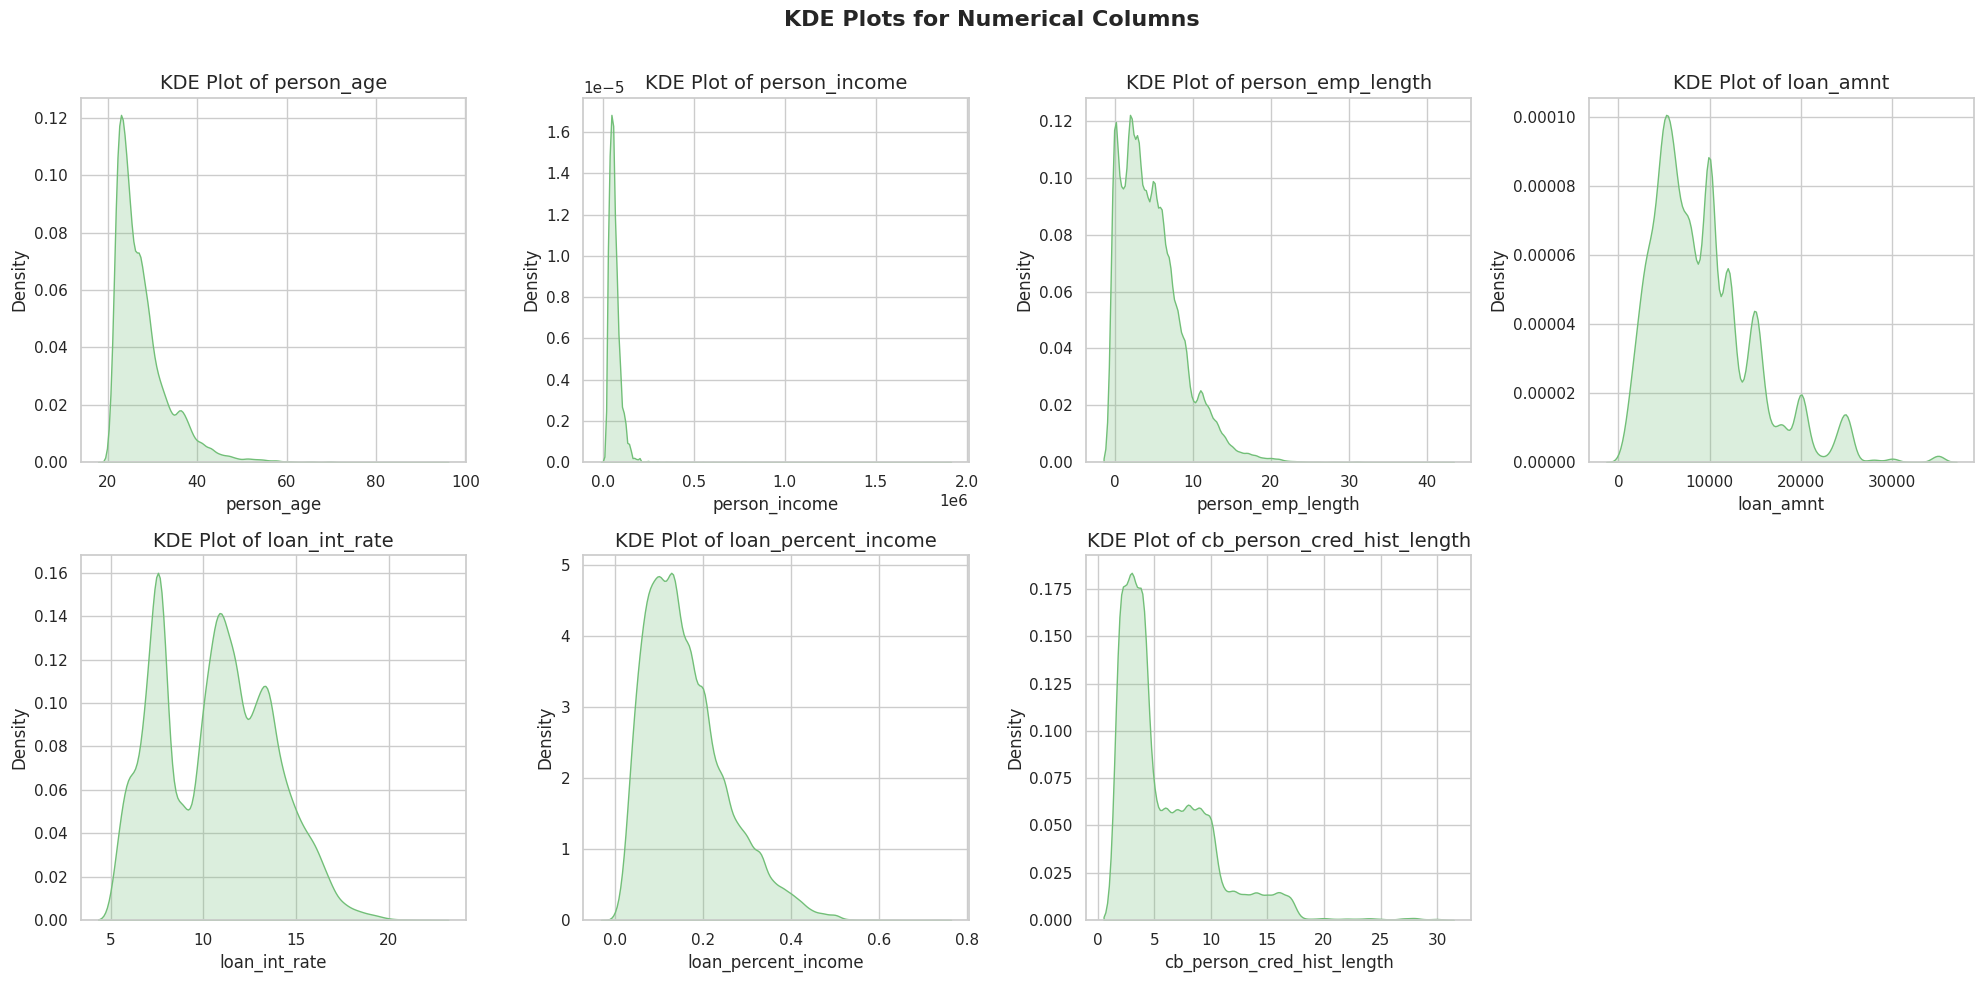

In [121]:
numerical_viz(test_data)

In [122]:
def numerical_viz_box_plot(X):
    '''
    Visualizes numerical data using box plots.

    Parameters:
    ----------
        X : pandas.DataFrame
            The DataFrame containing numerical columns to be visualized.
            
    Returns:
    -------
        None
            Displays a grid of box plots for each numerical column in the dataset.
            
    Description:
    -----------
        - This function identifies numerical columns using the `numerical_column` helper function.
        - It creates a 2x4 grid of subplots to display a box plot for each numerical column.
        - The layout is adjusted to remove any empty subplots and maintain clear spacing.
        - Each plot includes a title with the column name, x-axis label, and y-axis label for readability.
        - A main title is set for the overall plot layout.
    '''
    numerical_columns = numerical_column(X)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=X, y=column, ax=axes[i], color='#B8001F')
        axes[i].set_title(f'Plot of {column}', fontsize=14)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Box Plots for Columns', fontsize=16, fontweight='bold')
    plt.show()

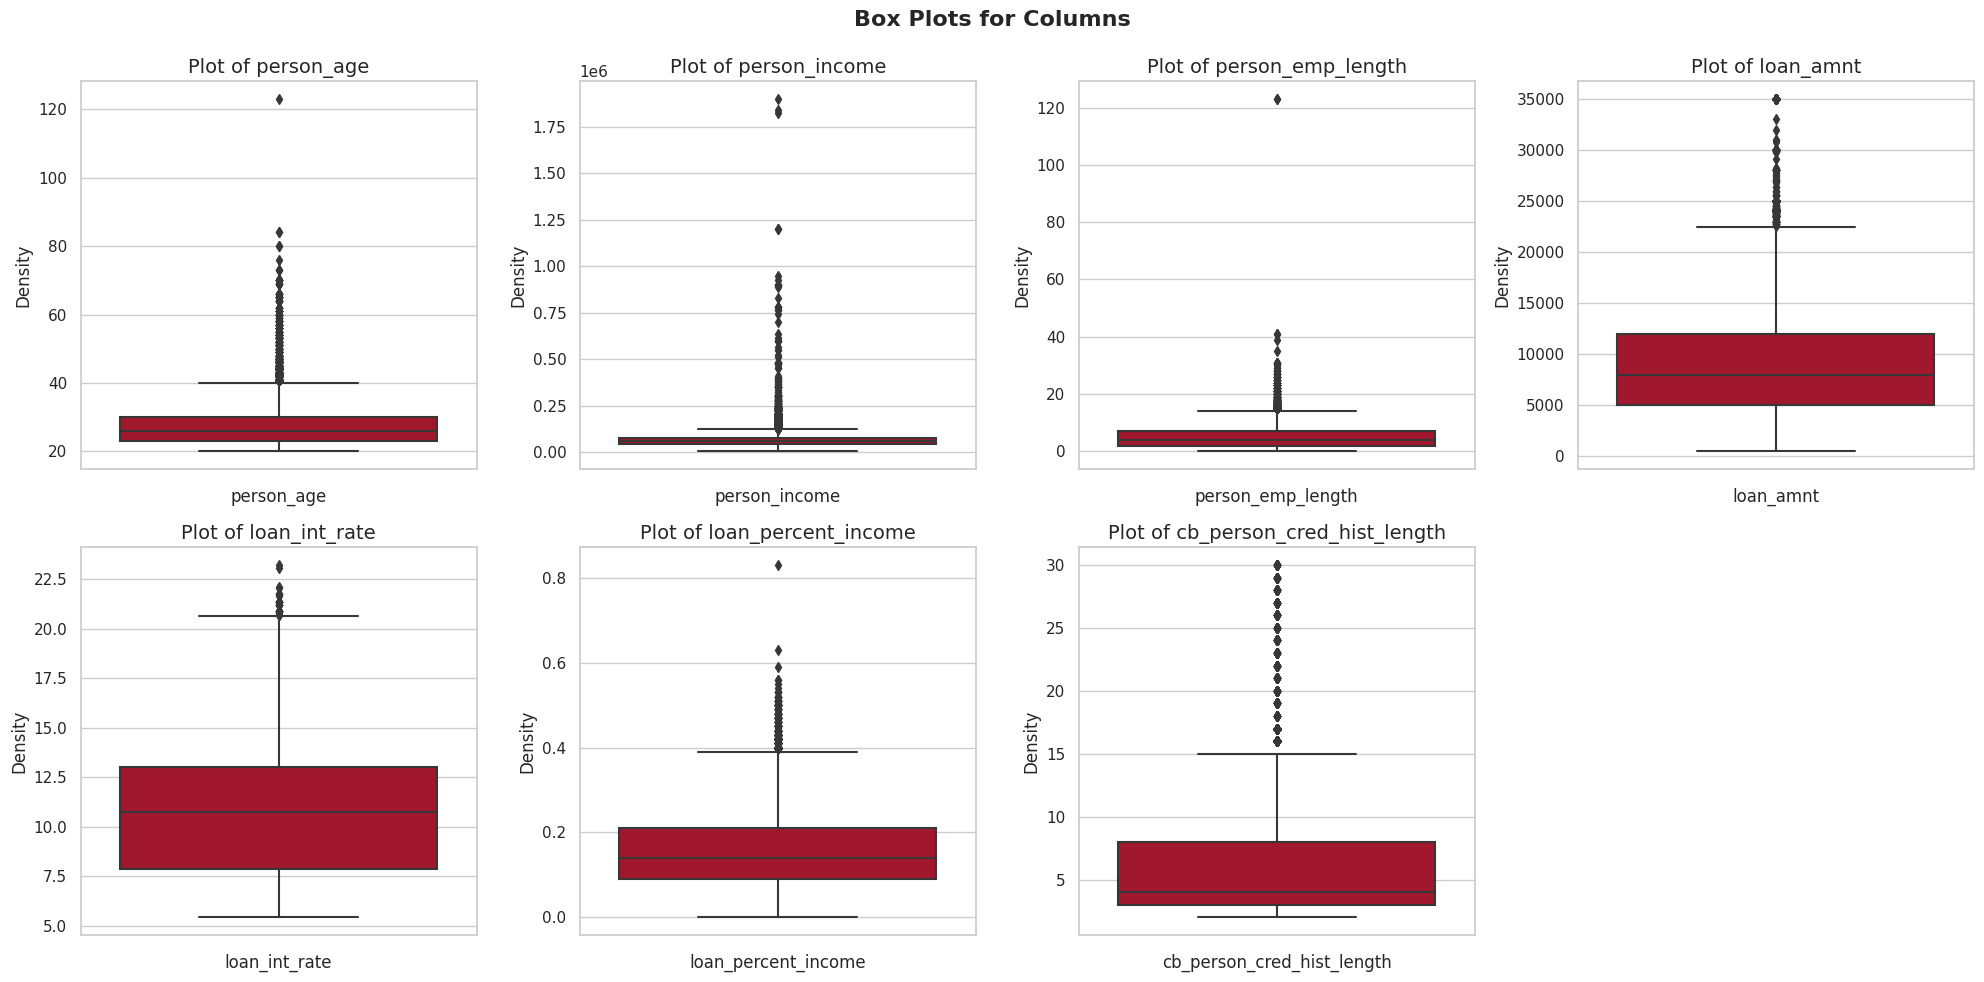

In [123]:
numerical_viz_box_plot(X)

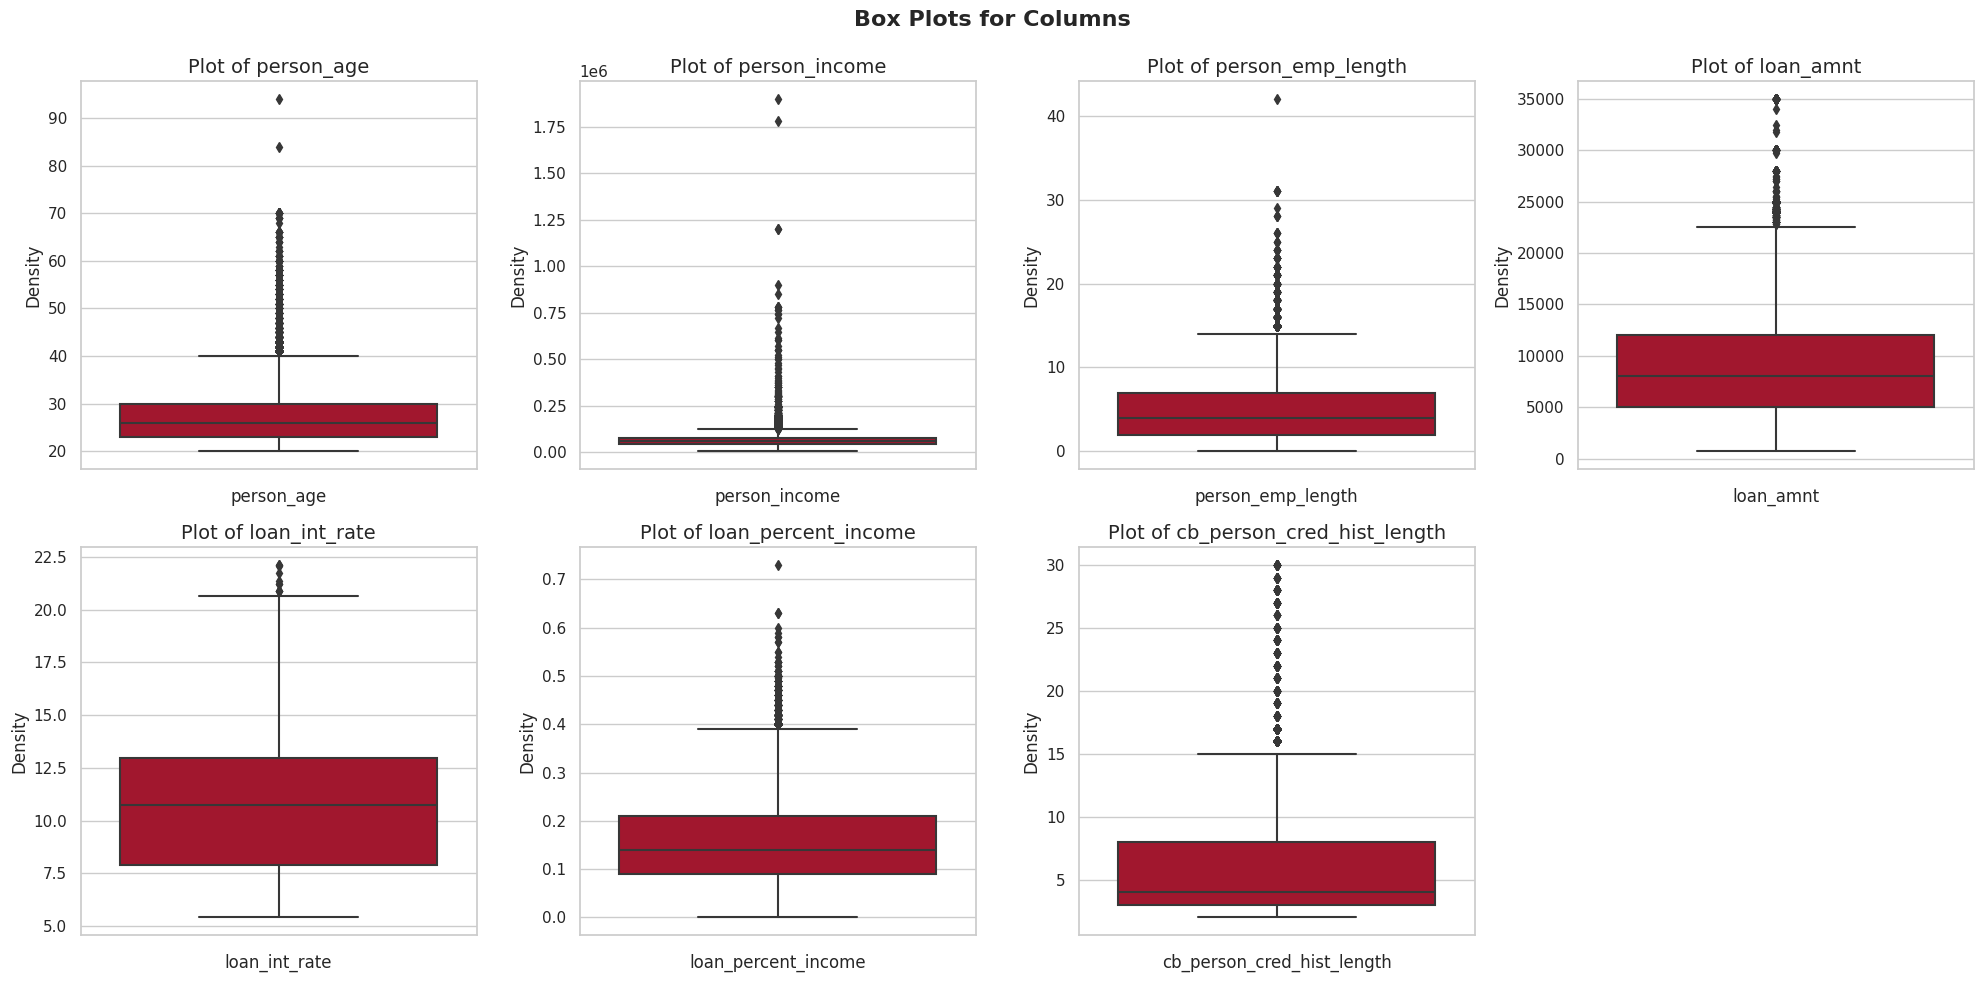

In [124]:
numerical_viz_box_plot(test_data)

In [125]:
X = pd.get_dummies(X).astype(int)
test_data = pd.get_dummies(test_data).astype(int)

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [127]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
# test_data = sc.fit_transform(test_data)

In [128]:
def evaluate_model(y_test, y_pred, X_test, model_name):
    """
    Evaluates the performance of a model using various metrics.
    
    Parameters:
    ----------
    y_test : array-like
        True labels for the test set.
    y_pred : array-like
        Predicted labels for the test set.
    model : object
        The trained model used for predictions.
    X_test : array-like
        Test features for the model.
        
    Returns:
    -------
    results_df : pandas.DataFrame
        A DataFrame containing the evaluation metrics.
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'model_name': [model_name],  # Include the model name
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1],
    })
    return results_df

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

## Logistic

In [130]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
logistic_df = evaluate_model(y_test, y_pred, X_test, 'Logistic')

Accuracy: 0.88
Precision: 0.68
Recall: 0.32
F1 Score: 0.44


## Decision Tree

In [131]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
dtc_df = evaluate_model(y_test, y_pred, X_test, 'Decision')

Accuracy: 0.91
Precision: 0.67
Recall: 0.72
F1 Score: 0.69


In [132]:
dtc_cv = DecisionTreeClassifier()
cross_val_score(dtc_cv, X_train, y_train , cv = 3).mean()

0.9073834474307941

## Decision Random Search

In [133]:
dtc_hpy = DecisionTreeClassifier(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(dtc_hpy, param_distributions=param_dist, n_iter=100, cv=5,
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)

In [134]:
dtc_hpy_ran_df = evaluate_model(y_test, y_pred, X_test, 'Dec Ran Hyp')

Accuracy: 0.95
Precision: 0.92
Recall: 0.67
F1 Score: 0.78


# RandomForest Search 

In [135]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf = evaluate_model(y_test, y_pred, X_test, 'Ran For')

Accuracy: 0.95
Precision: 0.91
Recall: 0.68
F1 Score: 0.78


## XGBoost

In [136]:
xgb = XGBClassifier(tree_method='gpu_hist')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_df = evaluate_model(y_test, y_pred, X_test, 'XGB')

Accuracy: 0.95
Precision: 0.89
Recall: 0.72
F1 Score: 0.80


## Catboost

In [137]:
cat = CatBoostClassifier(random_state=42, task_type='GPU', verbose=0)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
cat_df = evaluate_model(y_test, y_pred, X_test, 'Cat')

Accuracy: 0.95
Precision: 0.92
Recall: 0.71
F1 Score: 0.80


## Stacking


In [138]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))
]
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()
)
stacked_model.fit(X_train, y_train)
y_pred = stacked_model.predict(X_test)
stacked_model_df = evaluate_model(y_test, y_pred, X_test, 'stacked')

Accuracy: 0.95
Precision: 0.91
Recall: 0.73
F1 Score: 0.81


In [139]:
df = pd.concat([logistic_df,
                dtc_df,
                xgb_df, 
                cat_df, 
                stacked_model_df], ignore_index=True)
df

,model_name,accuracy,precision,recall,f1_score
0,Logistic,0.883654,0.678571,0.323470,0.438100
1,Decision,0.911333,0.672499,0.716660,0.693878
2,XGB,0.949244,0.893500,0.724362,0.800090
3,Cat,0.951177,0.919187,0.714633,0.804105
4,stacked,0.951915,0.909550,0.729631,0.809717


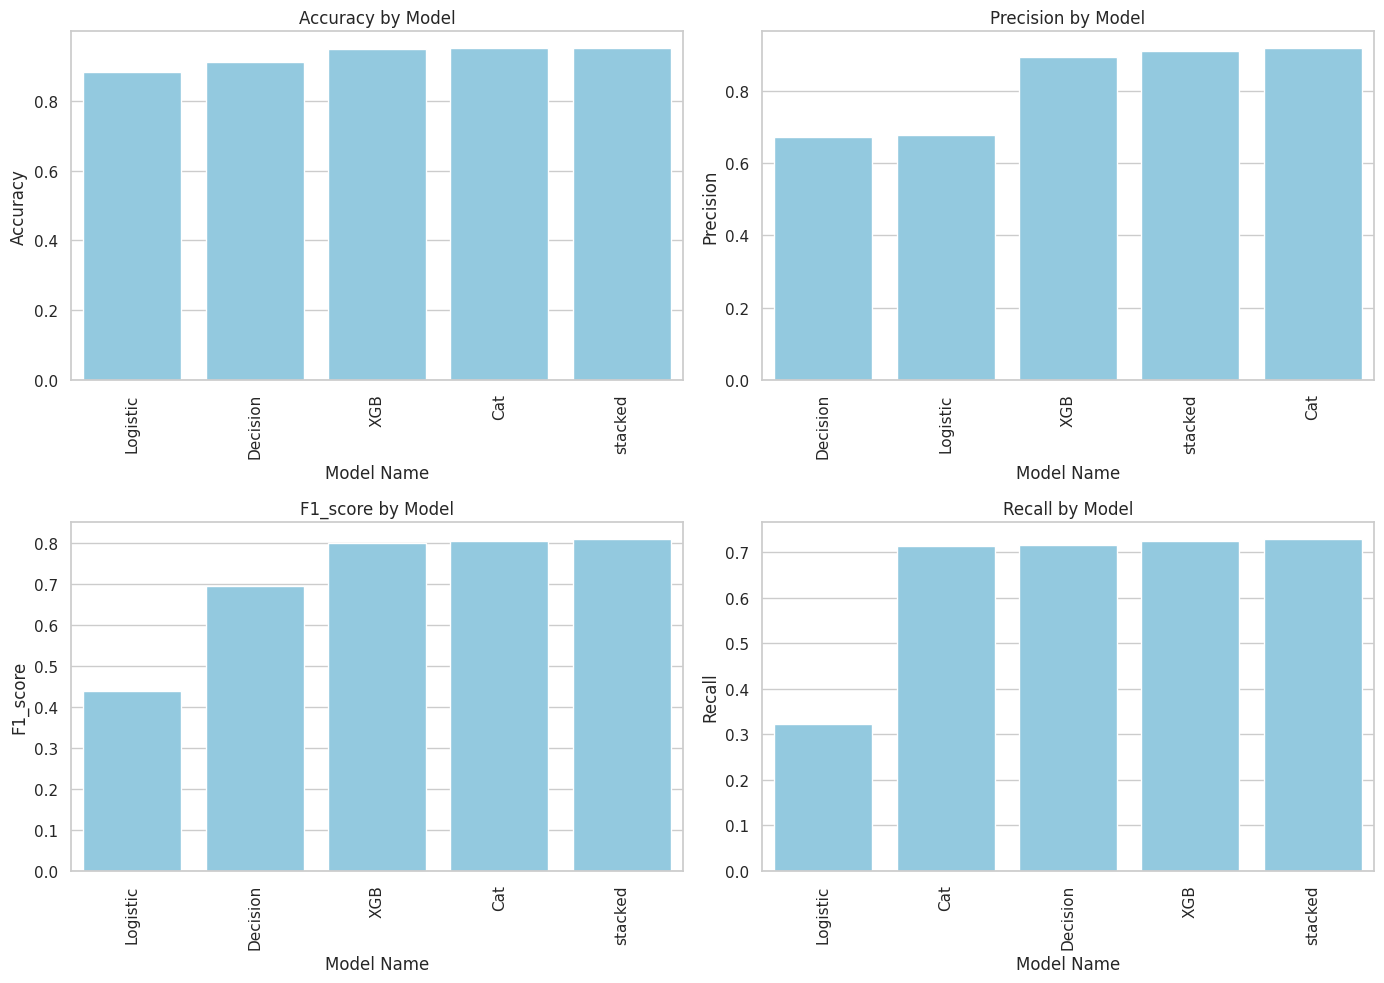

In [140]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision', 'f1_score', 'recall']
for ax, metric in zip(axes.flatten(), metrics):
    sorted_df = df.sort_values(by=metric, ascending=True)
    sns.barplot(x='model_name', y=metric, data=sorted_df, color='skyblue', ax=ax)
    ax.set_title(f'{metric.capitalize()} by Model')
    ax.set_xlabel('Model Name')
    ax.set_ylabel(metric.capitalize())
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [160]:
prediction = stacked_model.predict_proba(test_data)[:,1]
submission = pd.DataFrame({
    'id': test_data_id, # Replace with the actual test ID column
    'loan_status': prediction  # Ensure this matches the expected format
})

In [161]:
submission.to_csv('submission.csv', index=False)